In [1]:
import random
import sys
import matplotlib.pyplot as plt
from IPython.display import clear_output
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.basilisk_amm import ConstantProductPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import steady_swaps, constant_product_arbitrage, invest_all
from model.amm.global_state import GlobalState, fluctuate_prices

# same seed, same parameters = same simulation result
random.seed(42)

price_dict = {
    'R1': 3,
    'R2': 0.7,
    'USD': 1
}

initial_state = GlobalState(
    pools={
        # 'USD/R1': ConstantProductPoolState(
        #     tokens={
        #         'USD': 10000000,
        #         'R1': 10000000 / price_dict['R1']
        #     },
        #     trade_fee=0.01
        # ),
        'R1/R2': ConstantProductPoolState(
            tokens={
                'R1': 10000000 / price_dict['R1'],
                'R2': 10000000 / price_dict['R2']
            },
            trade_fee=0.01
        )
    },
    agents = {
        'LP': Agent(
            holdings={'R1': 1000000, 'R2': 1000000},
            trade_strategy=invest_all(pool_id='R1/R2')
        ),
        'Trader1': Agent(
            holdings={'R1': 10000000, 'R2': 42000000}
        ),
        'Trader2': Agent(
            holdings={'R1': 10000000, 'R2': 42000000}
        ),
        'Arbitrageur': Agent(
            holdings={'R1': 100000, 'R2': 1000000, 'USD': 0},
            trade_strategy=constant_product_arbitrage('R1/R2')
        )
    },
    external_market=price_dict,
    evolve_function=fluctuate_prices(volatility={'R1': 1, 'R2': 0.1, 'USD': 0})
)

events = []
raw_events = []
for i in range(100):
    # have the traders trade in opposite directions so it won't force equal levels of arbitrage
    copy_state = initial_state.copy()
    copy_state.agents['Trader1'].trade_strategy=steady_swaps(
        pool_id='R1/R2',
        usd_amount=i+1,
        asset_list=['R1', 'R2']
    )
    copy_state.agents['Trader2'].trade_strategy=steady_swaps(
        pool_id='R1/R2',
        usd_amount=i+1,
        asset_list=['R2', 'R1']
    )
    clear_output(wait=True)
    print(f'Running simulation... {i}%')
    raw_events.append(
        run.run(copy_state, time_steps=100, silent=True),
    )
    events.append(
        processing.postprocessing(
            raw_events[i], ['impermanent_loss', 'trade_volume', 'pool_val']
        )
    )
    
print('finished.')

Running simulation... 99%
finished.


In [11]:
arbitrage_fraction=[]
LP_profit = []
pool_profit = []
for run in events:
    trader_volume = sum(
        pu.get_datastream(run, agent='Trader1', prop='trade_volume') +
        pu.get_datastream(run, agent='Trader2', prop='trade_volume')
    )
    
    arb_volume = sum(
        pu.get_datastream(run, agent='Arbitrageur', prop='trade_volume')
    )
    
    arbitrage_fraction.append(arb_volume / (arb_volume + trader_volume))
    
    LP_profit.append(
        run[-1]['state'].agents['LP'].withdraw_val
        - run[0]['state'].agents['LP'].withdraw_val
    )
    
    pool_profit.append(
        run[-1]['state'].pools['R1/R2'].pool_val / run[-1]['state'].agents['LP'].withdraw_val
    )
    

<AxesSubplot:title={'center':'pool: R1/R2 pool_val  '}>

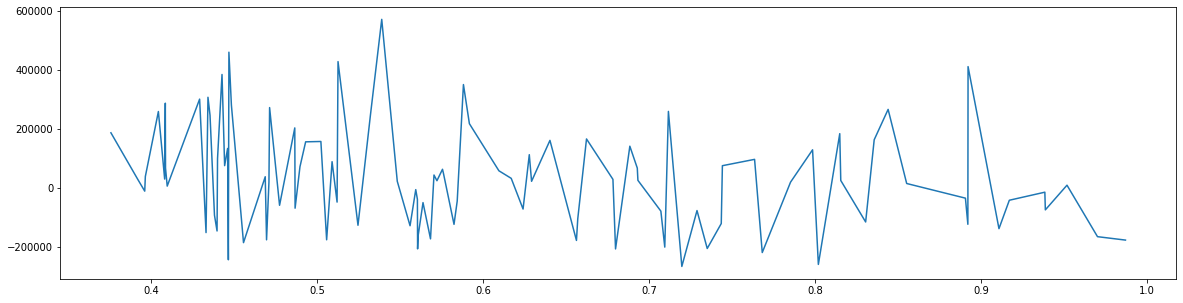

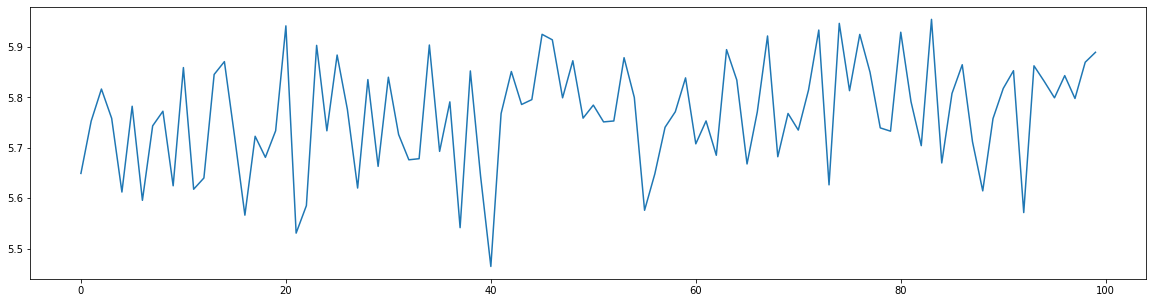

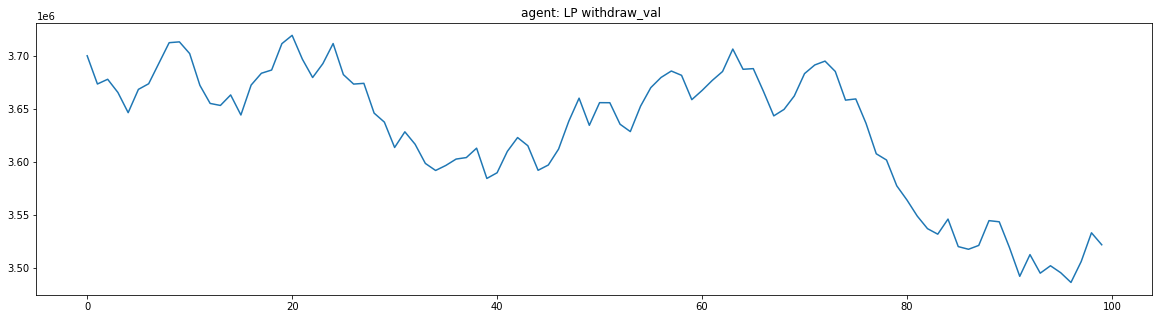

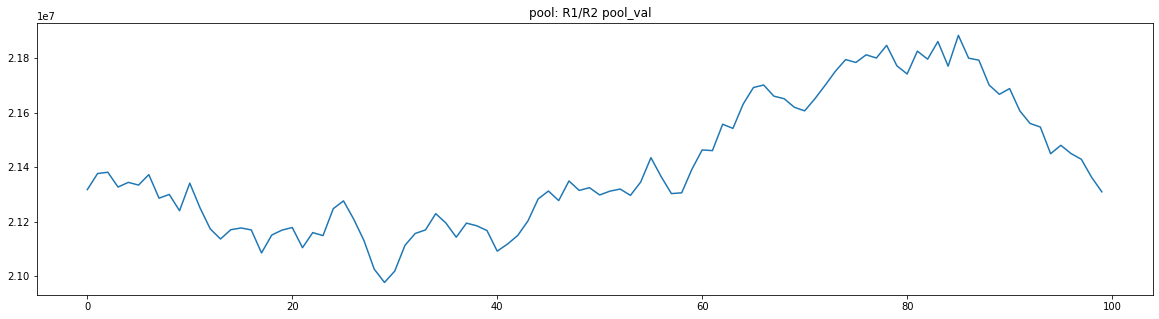

In [12]:
plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(sorted(arbitrage_fraction), LP_profit)

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(range(len(events)), pool_profit)

runs = len(events)
pu.plot(events[-1], agent='LP', prop='withdraw_val')
events[2] = processing.postprocessing(events[2], ['pool_val'])
pu.plot(events[2], pool='R1/R2', prop='pool_val')

100


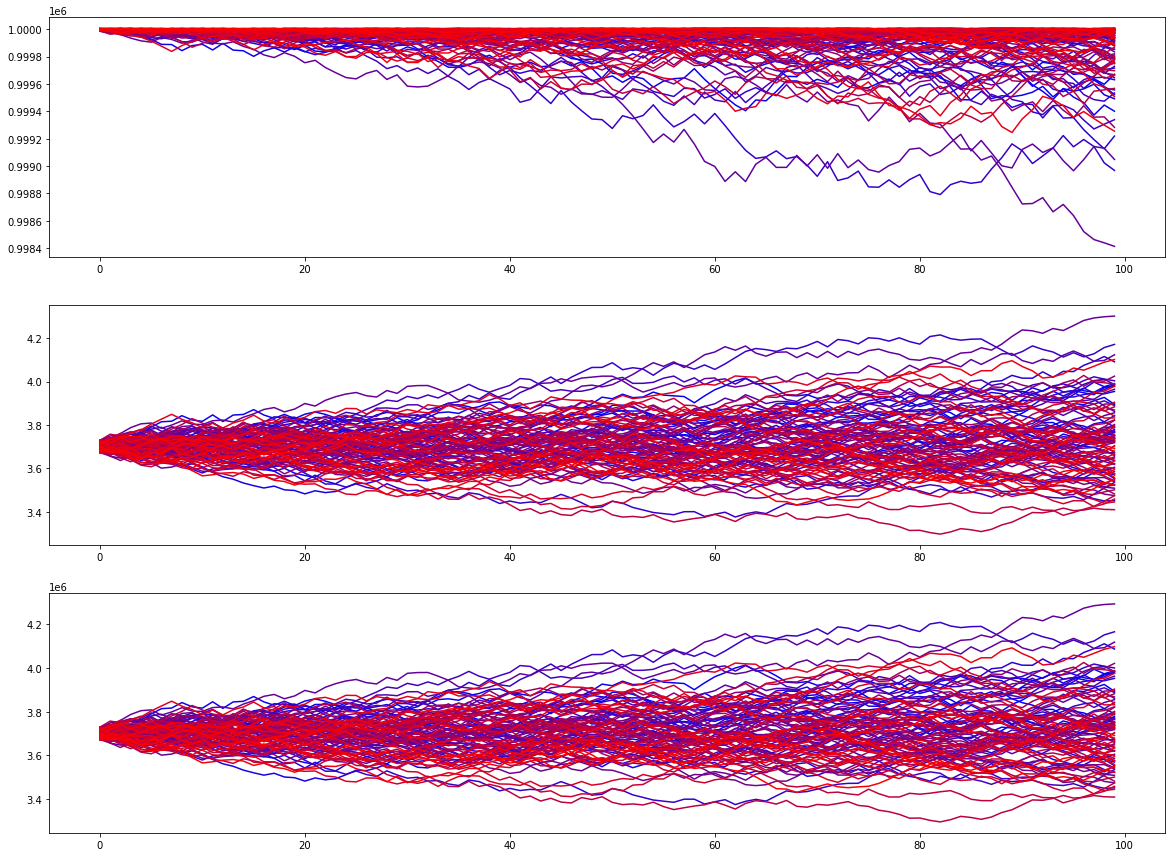

In [9]:
# define a red/blue spectrum, with blue being the beginning of the simulation (low trade volume) and red being the end (high)
color = [f'#{hex(int(i * 255 / runs))[2:].zfill(2)}00{hex(int(255 - i * 255 / runs))[2:].zfill(2)}' for i in range(runs)]
print(len(events))
plt.figure(figsize=(20, 15))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

for i, run in enumerate(events):
    LP_holdings = pu.get_datastream(run, agent='LP', prop='withdraw_val')
    R1_val = pu.get_datastream(run, asset='R1')
    R2_val = pu.get_datastream(run, asset='R2')
    ax1.plot(range(len(run)), [LP_holdings[j] / (R1_val[j] + R2_val[j]) for j in range(len(run))], color=color[i], label=i)
    ax2.plot(range(len(run)), [(R1_val[j] + R2_val[j]) for j in range(len(run))], color=color[i], label=i)
    ax3.plot(range(len(run)), [LP_holdings[j] for j in range(len(run))], color=color[i], label=i)
    # ax2.plot(range(len(run)), pu.get_datastream(run, agent='Arbitrageur2', prop='trade_volume'))
# plt.legend()

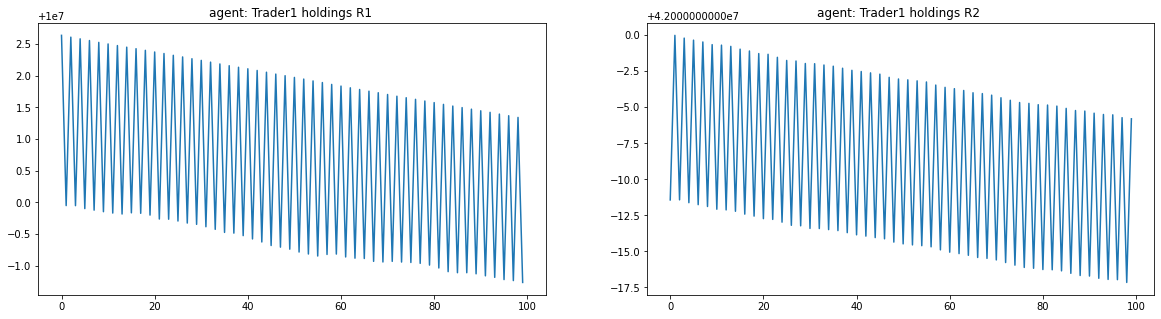

In [5]:
# for i, run in enumerate(events):
#     total_volume = sum(pu.get_datastream(run, agent='Arbitrageur', prop='trade_volume'))
#     if total_volume > 0:
#         print(total_volume, i)

ax = None
for run in events[7:8]:
    ax = pu.plot(run, agent='Trader1', prop='holdings', subplot=ax)


# ax = pu.plot(events[7], 

<AxesSubplot:title={'center':'agent: Arbitrageur trade_volume  '}>

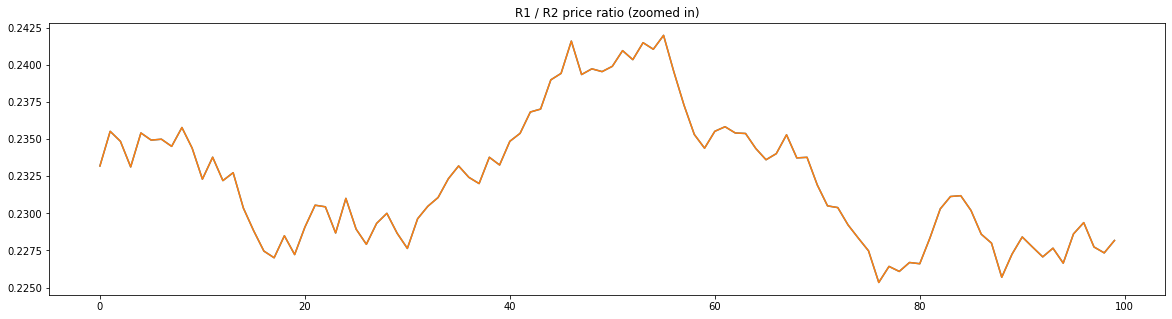

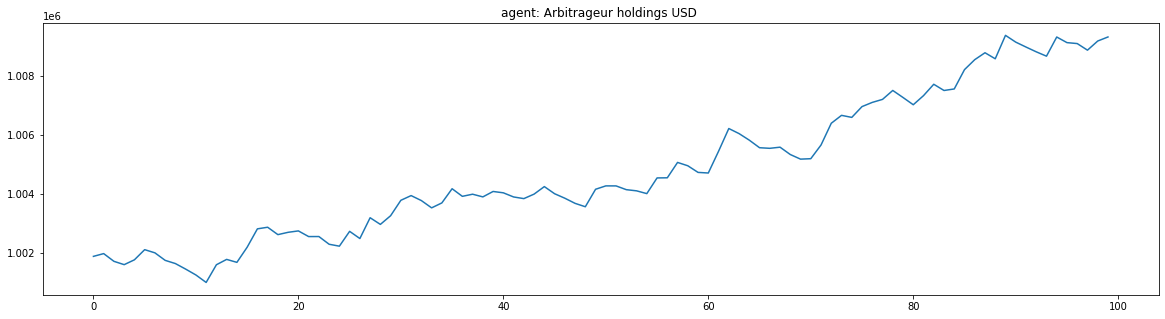

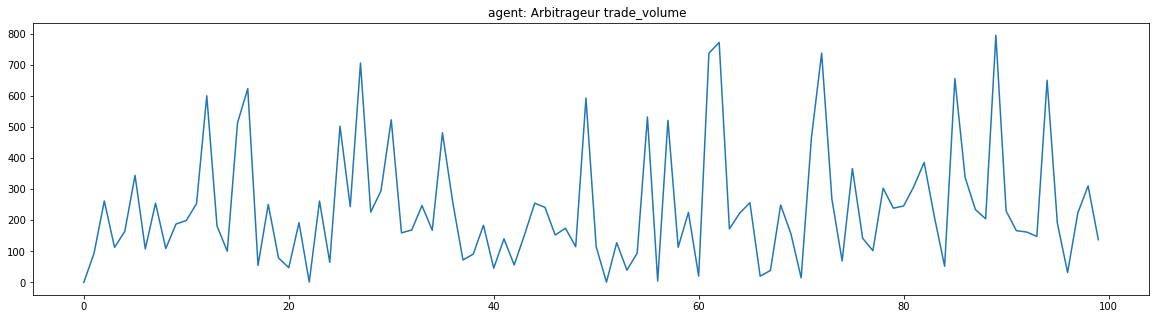

In [6]:
run = events[7]
R2_pool = pu.get_datastream(run, pool='R1/R2', prop='liquidity', key='R2')
R1_pool = pu.get_datastream(run, pool='R1/R2', prop='liquidity', key='R1')
R1_price = pu.get_datastream(run, asset='R1')
R2_price = pu.get_datastream(run, asset='R2')
pool_ratio = [R1_pool[i] / R2_pool[i] for i in range(len(events))]
price_ratio = [R2_price[i] / R1_price[i] for i in range(len(events))]
plt.figure(figsize=(20,5))
ax = plt.subplot(111, title='R1 / R2 price ratio (zoomed in)')
ax.plot(range(100), pool_ratio[:100], label='Ratio of R1 to R2 liquidity in pool')
ax.plot(range(100), price_ratio[:100], label='R2 / R1 spot price in the external market')
# ax.legend() 
pu.plot(events[5], agent='Arbitrageur', prop='holdings', key='USD')
pu.plot(events[5], agent='Arbitrageur', prop='trade_volume')

<AxesSubplot:title={'center':'asset price: R2   '}>

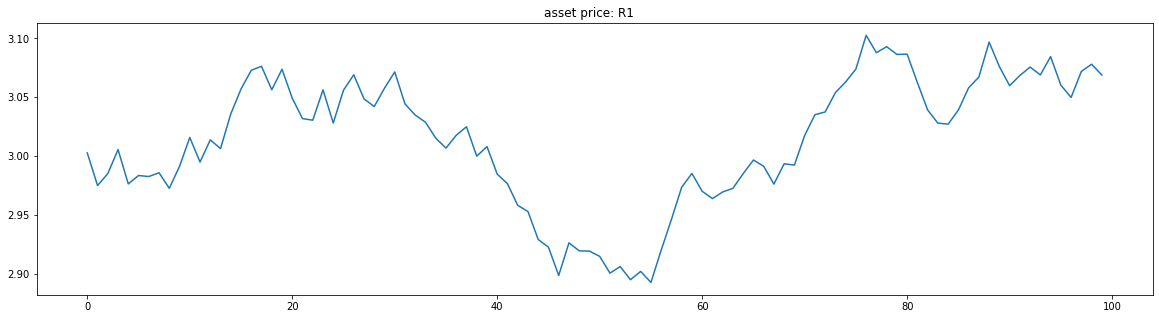

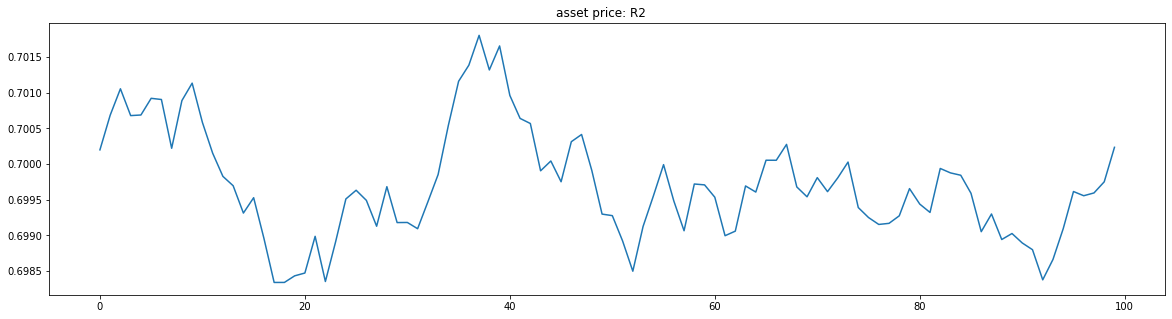

In [7]:
# plt.figure(figsize=(20,5))
# ax = plt.subplot(111, title='asset price')
pu.plot(run, asset='R1')
pu.plot(run, asset='R2')


In [8]:
print(events[0][1]['state'])
print('-------------------')
print(events[1][1]['state'])
print(repr(events[0][1]['state']) == repr(raw_events[0][1]['state']))

global state 
pools: 
Constant Product Pool
base trade fee: 0.010000000000000000208166817117216851329430937767029
shares: 3566666.6666666668066754937171936052156540064572708
tokens: (
    R1
    quantity: 3570570.7108286739836531768980332190653115294689135
    weight: 0.18952339227514056853806535504295658939292065424897
)
(
    R2
    quantity: 15269165.471421051999310585355749031065906828470009
    weight: 0.81047660772485943146193464495704341060707934575103

)
agents: 
Agent:
name: LP
trade strategy: invest all (R1/R2)
holdings: (
    R1: 766666.66666666668187826871871948072184599354272924
)
(
    R2: 0.0
)
shares: (
    R1/R2: 233333.33333333331812173128128051927815400645727077
    price: 4.2857142857142859936824866703578273913596444596617
)

Agent:
name: Trader1
trade strategy: steady swaps ($1)
holdings: (
    R1: 9999999.9960944054817274746166025222547074750822688
)
(
    R2: 41999999.993470741806962658396825022930211987186169
)
shares: (
)

Agent:
name: Trader2
trade strategy: s